In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers

In [2]:
number = 100
path_child = os.listdir('image-data/child')
path_elder = os.listdir('image-data/elder')
path_test = os.listdir('image-data/test')
path_child_test = os.listdir('image-data/child_test')

In [3]:
img_child = []
img_elder = []
img_test = []
img_child_test= []

In [4]:
input_tensor = Input(shape=(50, 50, 3))

In [5]:
for i in range(len(path_child)):
    img = cv2.imread('image-data/child/' + path_child[i])
    if(type(img) != type(None)):
        img = cv2.resize(img ,(50,50))
        img_child.append(img)
for i in range(len(path_elder)):
    img = cv2.imread('image-data/elder/' + path_elder[i])
    if(type(img) != type(None)):
        img = cv2.resize(img, (50,50))
        img_elder.append(img)

for i in range(len(path_test)):
    img = cv2.imread('image-data/test/' + path_test[i])
    if(type(img) != type(None)):
        img = cv2.resize(img, (50,50))
        img_test.append(img)

for i in range(len(path_child_test)):
    img = cv2.imread('image-data/child_test/' + path_child_test[i])
    if(type(img) != type(None)):
        img = cv2.resize(img, (50,50))
        img_child_test.append(img)

In [6]:
X = np.array(img_child + img_elder)
y =  np.array([0]*len(img_child) + [1]*len(img_elder))

X_t = np.array(img_child_test + img_test)
y_t = np.array([0]*len(img_test) +[1]*len(img_child_test))

rand_index = np.random.permutation(np.arange(len(X)))
rand_index_2 = np.random.permutation(np.arange(len(X_t)))

X = X[rand_index]
y = y[rand_index]

X_t = X_t[rand_index_2]
y_t = y_t[rand_index_2]

In [7]:
# データの分割
X_train = X[:int(len(X)*0.8)]
y_train = y[:int(len(y)*0.8)]
X_test = X_t[int(len(X_t)*0.8):]  
y_test = y_t[int(len(y_t)*0.8):] 

In [8]:
# 正解ラベルをone-hotの形にします
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [9]:
# モデルにvggを使います
input_tensor = Input(shape=(50, 50, 3))
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

# vggのoutputを受け取り、2クラス分類する層を定義します
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(2, activation='softmax'))

In [10]:
model = Model(inputs=vgg16.input, outputs=top_model(vgg16.output))
#model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None)

In [11]:
# vggの層の重みを変更不能にします
for layer in top_model.layers[:15]:
    layer.trainable = False

In [12]:
# コンパイルします
model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                  metrics=['accuracy'])

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [14]:
# 学習を行います
model.fit(X_train, y_train, batch_size=100, epochs=20, validation_data=(X_test, y_test))

Train on 480 samples, validate on 25 samples
Epoch 1/20
480/480 [==============================] - 18s 38ms/sample - loss: 6.8614 - accuracy: 0.5667 - val_loss: 4.1331 - val_accuracy: 0.3200
Epoch 2/20
480/480 [==============================] - 16s 34ms/sample - loss: 1.9613 - accuracy: 0.5396 - val_loss: 2.6043 - val_accuracy: 0.3200
Epoch 3/20
480/480 [==============================] - 17s 36ms/sample - loss: 0.9284 - accuracy: 0.6354 - val_loss: 2.1746 - val_accuracy: 0.2400
Epoch 4/20
480/480 [==============================] - 17s 36ms/sample - loss: 0.6363 - accuracy: 0.6562 - val_loss: 1.5782 - val_accuracy: 0.3200
Epoch 5/20
480/480 [==============================] - 18s 37ms/sample - loss: 0.6143 - accuracy: 0.6896 - val_loss: 1.4778 - val_accuracy: 0.3600
Epoch 6/20
480/480 [==============================] - 17s 36ms/sample - loss: 0.5857 - accuracy: 0.7042 - val_loss: 1.5463 - val_accuracy: 0.3200
Epoch 7/20
480/480 [==============================] - 17s 35ms/sample - loss: 0

In [15]:
def child(img):
    img = cv2.resize(img, (50, 50))
    pred = np.argmax(model.predict(np.array([img])))
    if pred == 0:
        return 'これは子供です'
    else:
        return 'これは老人です'

25/25 [==============================] - 0s 14ms/sample - loss: 2.7830 - accuracy: 0.3200
Test loss 間違い具合: 2.782970666885376
Test accuracy 正解率: 0.32


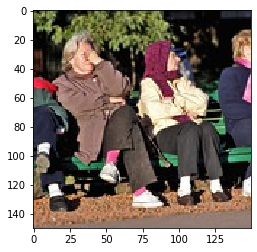

これは老人です


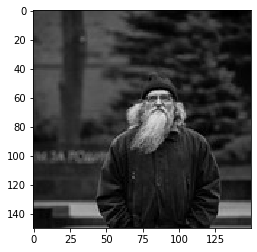

これは老人です


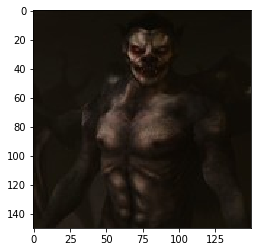

これは老人です


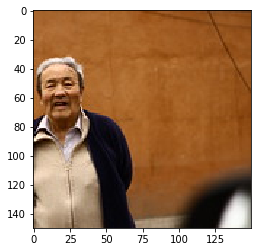

これは子供です


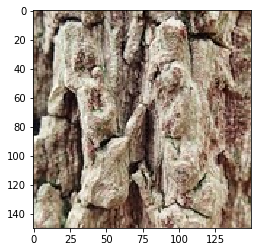

これは老人です


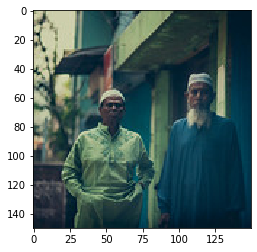

これは老人です


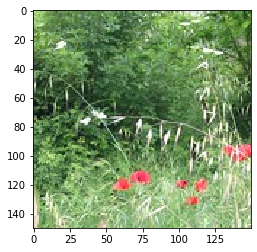

これは老人です


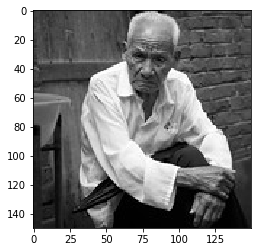

これは子供です


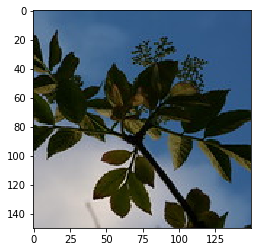

これは老人です


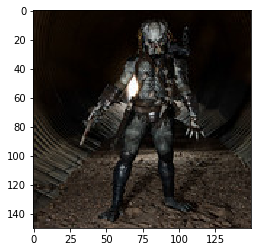

これは老人です


In [19]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss 間違い具合:', scores[0])
print('Test accuracy 正解率:', scores[1])

# child関数に画像を渡して判別させます
for i in range(10):
    img = cv2.imread('image-data/elder/' + path_elder[i])
    if(type(img) != type(None)):
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b])
        plt.imshow(img)
        plt.show()
        print(child(img))    

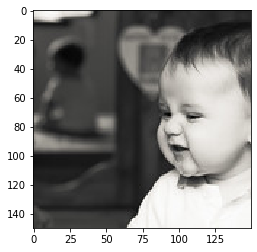

これは子供です


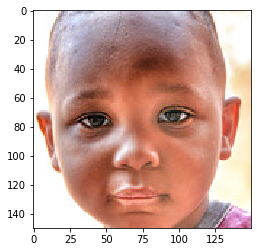

これは子供です


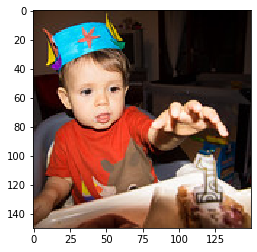

これは子供です


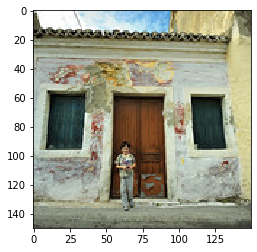

これは子供です


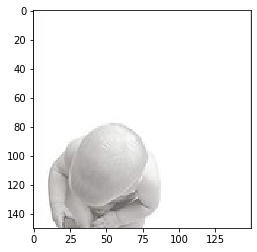

これは子供です


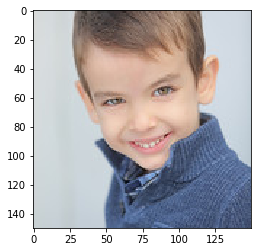

これは子供です


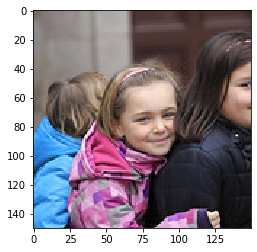

これは子供です


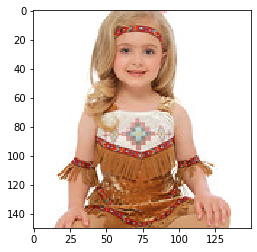

これは子供です


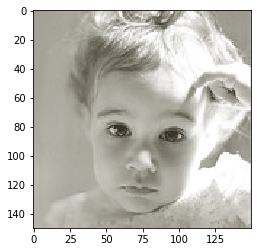

これは子供です


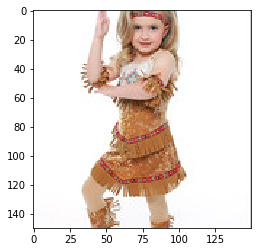

これは子供です


In [17]:
for i in range(10):
    img = cv2.imread('image-data/child/' + path_child[i])
    if(type(img) != type(None)):
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b])
        plt.imshow(img)
        plt.show()
        print(child(img))    